###Baseado no exemplo - 6.1 de Estática Mecânica Para Engenharia 14ª Edição - Hibbeler

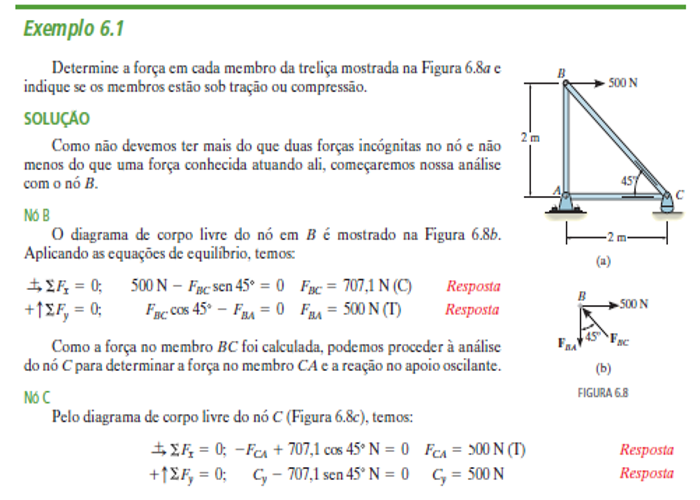

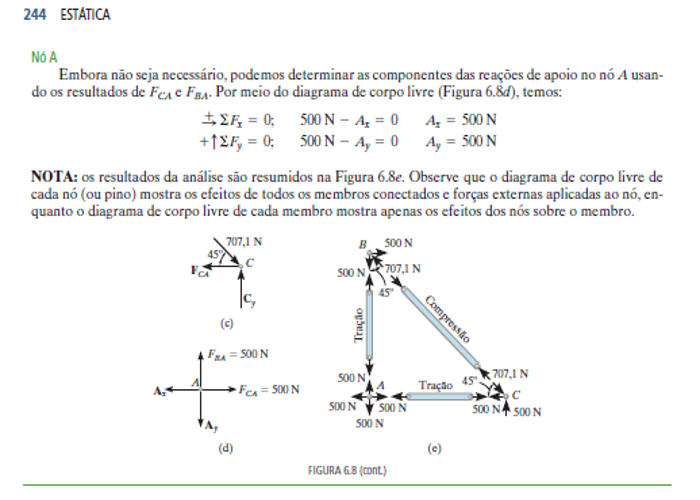

In [84]:
import requests
from PIL import Image
from io import BytesIO

file_id = '18mnP5F-Rt_qWPWbxEY66gjwGhJD1Jrle'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (700, 500)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/18mnP5F-Rt_qWPWbxEY66gjwGhJD1Jrle/view?usp=drive_link

file_id = '1tgWi1Ty20SmCV5y3VdvSfTKqAJZaaQIj'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (700, 500)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/1tgWi1Ty20SmCV5y3VdvSfTKqAJZaaQIj/view?usp=drive_link

###**1. Funções de Mapeamento e Rigidez**



A função `calcular_matriz_rigidez_global_elemento(A, E, L, theta_rad):` calcula a matriz que define o quão rígida é o elemento barra da treliça.

Estes são os cossenos diretores `c = math.cos(theta_rad)`, `s = math.sin(theta_rad)`.

 Eles funcionam como a matriz de rotação $(T)$, que transforma os esforços/deslocamentos do sistema de coordenadas local da barra (apenas axial) para o sistema de coordenadas global (horizontal e vertical).

In [85]:
import numpy as np
import math

def calcular_matriz_rigidez_global_elemento(A, E, L, theta_rad):
    """Calcula a matriz de rigidez global (4x4) de uma barra."""
    c = math.cos(theta_rad)
    s = math.sin(theta_rad)


###**Matriz Global de Rigidez**

Termo Escalar:  $$\frac{AE}{L}$$

Esta é a rigidez axial (Lei de Hooke). É o termo que controla a rigidez de uma barra: quanto maior $A$ e $E$ e menor $L$, mais rígida ela é.

Matriz 4×4: É o resultado da transformação de coordenadas. Essa matriz, de fato, mapeia as forças globais $(F_x,F_y)$ nos dois nós do elemento para os deslocamentos globais $(u,v)$.

A função `montar_matriz_global(GDL_total, elementos)` implementa o processo de Montagem $(Assembly)$ do MEF. É aqui que a rigidez de todas as barras é combinada para formar a matriz de rigidez global $[K]$.

Para cada elemento, a função pega os termos da matriz de rigidez local ($K$
e, que é 4×4) e os adiciona nas posições corretas (definidas pelo `gdl_map`) da matriz global K. Este processo de adição é o que garante o equilíbrio de forças e a compatibilidade de deslocamentos em cada nó.

In [86]:
import numpy as np

def calcular_matriz_rigidez_global_elemento(A, E, L, theta_rad):
    """
    Calcula a matriz de rigidez global de um elemento de treliça 2D.
    """
    c = np.cos(theta_rad)
    s = np.sin(theta_rad)

    K_global_simplificada = (A * E / L) * np.array([
        [ c*c,  c*s, -c*c, -c*s],
        [ c*s,  s*s, -c*s, -s*s],
        [-c*c, -c*s,  c*c,  c*s],
        [-c*s, -s*s,  c*s,  s*s]
    ])
    return K_global_simplificada


def montar_matriz_global(GDL_total, elementos):

    K = np.zeros((GDL_total, GDL_total))

    for dados_elemento in elementos:
        A, E, L, theta_rad, gdl_map = dados_elemento
        K_e = calcular_matriz_rigidez_global_elemento(A, E, L, theta_rad)

        # Mapeamento dos GDLs locais para globais
        for i in range(4):
            gdl_global_i = gdl_map[i]
            for j in range(4):
                gdl_global_j = gdl_map[j]
                K[gdl_global_i, gdl_global_j] += K_e[i, j]

    return K


In [87]:
import numpy as np
import math

def calcular_matriz_rigidez_global_elemento(A, E, L, theta_rad):
    """Calcula a matriz de rigidez global (4x4) de uma barra."""
    c = math.cos(theta_rad)
    s = math.sin(theta_rad)

    K_global_simplificada = (A * E / L) * np.array([
        [c*c, c*s, -c*c, -c*s],
        [c*s, s*s, -c*s, -s*s],
        [-c*c, -c*s, c*c, c*s],
        [-c*s, -s*s, c*s, s*s]
    ])
    return K_global_simplificada

def montar_matriz_global(GDL_total, elementos):
    """Monta a matriz de rigidez global (K) somando as contribuições dos elementos."""
    K = np.zeros((GDL_total, GDL_total))

    for dados_elemento in elementos:
        A, E, L, theta_rad, gdl_map = dados_elemento

        K_e = calcular_matriz_rigidez_global_elemento(A, E, L, theta_rad)

        # Mapeamento
        # gdl_map contém os GDLs globais [u_i, v_i, u_j, v_j]

        for i in range(4):
            gdl_global_i = gdl_map[i]
            for j in range(4):
                gdl_global_j = gdl_map[j]
                K[gdl_global_i, gdl_global_j] += K_e[i, j]
    return K

###**Propriedades**

In [88]:

E = 200e9    # Módulo de Elasticidade do Aço (Pa) - Assumindo aço para referência.
A = 1e-4     # Área da seção (m²) - Assumindo uma área padrão para cálculo.


###**Coordenadas dos nós e Graus de Liberdade**

In [89]:
# Coordenadas [x, y]
coord_A = [0.0, 0.0]
coord_B = [0.0, 2.0]
coord_C = [2.0, 0.0]

# Mapeamento de GDL (Graus de Liberdade)
# Nó A: GDL 0, 1 (u_A, v_A)
# Nó B: GDL 2, 3 (u_B, v_B)
# Nó C: GDL 4, 5 (u_C, v_C)
GDL_total = 6

###**Definição das barras, comprimento e ângulo**

Esta função é essencial: ela calcula o comprimento $(L)$ e o ângulo $(θ)$ (em radianos, usando `atan2` para determinar o quadrante correto) a partir das coordenadas dos nós. Isso garante que a matriz de rigidez seja calculada com as dimensões e orientação corretas.

###Definição das Barras:

O vetor elementos armazena todos os dados de entrada necessários para cada barra (propriedades, comprimento, ângulo) e o `gdl_map`, que é o mapa que a função de montagem usa para saber onde inserir a matriz do elemento $K$
e na matriz global $K$.

In [90]:
# Função auxiliar para calcular Comprimento (L) e Ângulo (theta)
def get_propriedades_barra(coord_i, coord_j):
    dx = coord_j[0] - coord_i[0]
    dy = coord_j[1] - coord_i[1]
    L = math.sqrt(dx**2 + dy**2)
    theta_rad = math.atan2(dy, dx)
    return L, theta_rad

# Definição das Barras: (A, E, L, theta_rad, GDL_map)

# 1. Barra AB (Nó A -> Nó B)
L_AB, theta_AB = get_propriedades_barra(coord_A, coord_B)
gdl_AB = [0, 1, 2, 3] # uA, vA, uB, vB

# 2. Barra BC (Nó B -> Nó C)
L_BC, theta_BC = get_propriedades_barra(coord_B, coord_C)
gdl_BC = [2, 3, 4, 5] # uB, vB, uC, vC

# 3. Barra AC (Nó A -> Nó C)
L_AC, theta_AC = get_propriedades_barra(coord_A, coord_C)
gdl_AC = [0, 1, 4, 5] # uA, vA, uC, vC

elementos = [
    (A, E, L_AB, theta_AB, gdl_AB),
    (A, E, L_BC, theta_BC, gdl_BC),
    (A, E, L_AC, theta_AC, gdl_AC)
]

###**Aplicação de Condições de Contorno**

Os apoios fixos $(u_a,v_a)$ e o apoio móvel na vertical $(v_c)$ não se movem, removemos as linhas e colunas correspondentes (fixas) da matriz $K$ e do vetor $F$. Isso transforma a matriz $K$ global em $K$ reduzida, que é invertível.

O `numpy.linalg.solve` resolve eficientemente o sistema linear:
 $U_{livres} = K_{reduzida}^{-1} \, F_{reduzida}$

 O resultado são os deslocamentos nos GDLs livres (os únicos que podem se mover: $u_B,v_B,u_C$).

In [91]:
# 1. Montar K Global
K_global = montar_matriz_global(GDL_total, elementos)

# 2. Definir Vetor de Cargas (F)
# Carga de 500 N horizontal no Nó B (GDL 2)
F_global = np.array([0, 0, 500, 0, 0, 0])

# 3. Aplicar Condições de Contorno (CC)
# Nó A fixo (GDL 0, 1) e Nó C móvel (GDL 5 fixo)
GDL_fixos = [0, 1, 5]
GDL_livres = [gdl for gdl in range(GDL_total) if gdl not in GDL_fixos] # GDLs Livres: 2, 3, 4

# Reduzir Matriz K e Vetor F
K_reduzida = K_global[np.ix_(GDL_livres, GDL_livres)]
F_reduzida = F_global[GDL_livres]

# 4. Solução: Calcular Deslocamentos Livres
U_livres = np.linalg.solve(K_reduzida, F_reduzida)



###**Forças Internas**

Os deslocamentos $(U)$ são a solução primária. Agora, usamos eles para encontrar as forças internas $(F{int})$.

`u_e = U_global[gdl_map]` extrai apenas os 4 deslocamentos globais relevantes para aquela barra $(ex:u{A},v{A},u{B},v{B})$.

**Cálculo de deformação**

 A multiplicação do vetor de deslocamentos do elemento $(u_{e})$ pela matriz de rotação simplificada $(T_{axial})$ e divisão por $L$ nos dá a deformação axial $ϵ$.

 **Cálculo das forças internas** `F_interna = E * A * epsilon_e`

 A Lei de Hooke: $σ=Eϵ$
 Como $$σ=F/A$$, temos $$F_int=EAϵ$$

In [92]:


# 5. Reconstruir Vetor de Deslocamentos Global
U_global = np.zeros(GDL_total)
U_global[GDL_livres] = U_livres

# --- VALIDAÇÃO: CALCULAR FORÇAS INTERNAS ---

print(f"--- FORÇAS INTERNAS (RESULTADOS MEF) ---")
print(f"Propriedades Usadas: E={E:.0e} Pa, A={A:.0e} m²")

resultados_mef = {}
for i, dados_elemento in enumerate(elementos):
    A_e, E_e, L, theta_rad, gdl_map = dados_elemento
    c = math.cos(theta_rad)
    s = math.sin(theta_rad)

    # Vetor de deslocamentos globais para o elemento
    u_e = U_global[gdl_map]

    # Matriz de Transformação T (para calcular a deformação axial)
    T_axial = np.array([-c, -s, c, s])

    # Deformação Axial e Força Interna (F = E * A * epsilon)
    epsilon_e = (1/L) * (T_axial @ u_e)
    F_interna = E_e * A_e * epsilon_e

    # Mapeamento do nome da barra
    nome_barra = ["AB", "BC", "AC"][i]
    resultados_mef[nome_barra] = F_interna

    estado = "Tração (T)" if F_interna > 0.1 else "Compressão (C)" if F_interna < -0.1 else "Nulo"

    print(f"Barra {nome_barra} (L={L:.2f}m, θ={math.degrees(theta_rad):.0f}°): {F_interna:.1f} N -> {estado}")

print("\n--- COMPARAÇÃO DE RESULTADOS ---")
print(f"| Barra | MEF (N) | Solução Analítica (N) | Status |")
print(f"|:-----:|:-------:|:---------------------:|:------:|")
print(f"| AB    | {resultados_mef['AB']:.1f} (T) | 500.0 (T)             | {'OK' if abs(resultados_mef['AB'] - 500) < 1 else 'FALHA'} |")
print(f"| BC    | {resultados_mef['BC']:.1f} (C) | -707.1 (C)            | {'OK' if abs(resultados_mef['BC'] - (-707.1)) < 1 else 'FALHA'} |")
print(f"| AC    | {resultados_mef['AC']:.1f} (T) | 500.0 (T)             | {'OK' if abs(resultados_mef['AC'] - 500) < 1 else 'FALHA'} |")

--- FORÇAS INTERNAS (RESULTADOS MEF) ---
Propriedades Usadas: E=2e+11 Pa, A=1e-04 m²
Barra AB (L=2.00m, θ=90°): 500.0 N -> Tração (T)
Barra BC (L=2.83m, θ=-45°): -707.1 N -> Compressão (C)
Barra AC (L=2.00m, θ=0°): 500.0 N -> Tração (T)

--- COMPARAÇÃO DE RESULTADOS ---
| Barra | MEF (N) | Solução Analítica (N) | Status |
|:-----:|:-------:|:---------------------:|:------:|
| AB    | 500.0 (T) | 500.0 (T)             | OK |
| BC    | -707.1 (C) | -707.1 (C)            | OK |
| AC    | 500.0 (T) | 500.0 (T)             | OK |
